# Задача

Используя базу данных автомобилей, создайте сеть с точностью распознавания не ниже 93% на проверочной выборке.

Для решения задачи вы можете использовать любой подход:
- модель без аугментации данных
- аугментация данных с помощью ImageDataGenerator
- аугментация данных с помощью самописного генератора изображений
- использовать готовую архитектуру из набора `tf.keras.applications` (Обратите внимание: на занятии мы не рассматривали данный модуль фреймворка Керас. Ваша задача: попробовать самостоятельно разобраться в приципах его работы. В разборе домашнего задания вы получите ссылку на ноутбук Базы Знаний УИИ, где подробно раскрывается вопрос использования готовых архитектур)

# Решение с помощью ImageDataGenerator

## Загрузка библиотек

In [ ]:
# Работа с массивами
import numpy as np

# Генератор аугментированных изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Основа для создания последовательной модели
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Оптимизатор
from tensorflow.keras.optimizers import Adam

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Подключение модуля для загрузки данных из облака
import gdown

# Инструменты для работы с файлами
import os

# Отрисовка графиков
import matplotlib.pyplot as plt

# Рисование графиков в ячейках Colab
%matplotlib inline

## Задание гиперпараметров модели

In [ ]:
# Задание гиперпараметров

TRAIN_PATH          = '/content/cars'       # Папка для обучающего набора данных
TEST_PATH           = '/content/cars_test'  # Папка для тестового набора данных

TEST_SPLIT          = 0.1                   # Доля тестовых данных в общем наборе
VAL_SPLIT           = 0.2                   # Доля проверочной выборки в обучающем наборе

IMG_WIDTH           = 128                   # Ширина изображения для нейросети
IMG_HEIGHT          = 64                    # Высота изображения для нейросети
IMG_CHANNELS        = 3                     # Количество каналов (для RGB равно 3, для Grey равно 1)

# Параметры аугментации
ROTATION_RANGE      = 8                     # Пределы поворота
WIDTH_SHIFT_RANGE   = 0.15                  # Пределы сдвига по горизонтали
HEIGHT_SHIFT_RANGE  = 0.15                  # Пределы сдвига по вертикали
ZOOM_RANGE          = 0.15                  # Пределы увеличения/уменьшения
BRIGHTNESS_RANGE    = (0.7, 1.3)            # Пределы изменения яркости
HORIZONTAL_FLIP     = True                  # Горизонтальное отражение разрешено

EPOCHS              = 64                    # Число эпох обучения
BATCH_SIZE          = 24                    # Размер батча для обучения модели
OPTIMIZER           = Adam(0.0001)          # Оптимизатор

## Загрузка датасета и подготовка данных

In [ ]:
# Загрузка zip-архива с датасетом из облака на диск виртуальной машины colab
!wget -q 'https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip'

In [ ]:
# Очистка данных от прошлого запуска (если есть)
!rm -rf {TRAIN_PATH} {TEST_PATH}

# Разархивация датасета в директорию данных
!unzip -qo "middle_fmr.zip" -d {TRAIN_PATH}

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(TRAIN_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 3, метки классов: ['Ferrari', 'Mercedes', 'Renault']


In [ ]:
# Перенос файлов для теста в отдельное дерево папок, расчет размеров наборов данных

os.mkdir(TEST_PATH)                                        # Создание папки для тестовых данных
train_count = 0
test_count = 0

for class_name in CLASS_LIST:                              # Для всех классов по порядку номеров (их меток)
    class_path = f'{TRAIN_PATH}/{class_name}'              # Формирование полного пути к папке с изображениями класса
    test_path = f'{TEST_PATH}/{class_name}'                # Полный путь для тестовых данных класса
    class_files = os.listdir(class_path)                   # Получение списка имен файлов с изображениями текущего класса
    class_file_count = len(class_files)                    # Получение общего числа файлов класса
    os.mkdir(test_path)                                    # Создание подпапки класса для тестовых данных
    test_file_count = int(class_file_count * TEST_SPLIT)   # Определение числа тестовых файлов для класса
    test_files = class_files[-test_file_count:]            # Выделение файлов для теста от конца списка
    for f in test_files:                                   # Перемещение тестовых файлов в папку для теста
        os.rename(f'{class_path}/{f}', f'{test_path}/{f}')
    train_count += class_file_count                        # Увеличение общего счетчика файлов обучающего набора
    test_count += test_file_count                          # Увеличение общего счетчика файлов тестового набора

    print(f'Размер класса {class_name}: {class_file_count} машин, для теста выделено файлов: {test_file_count}')

print(f'Общий размер базы: {train_count}, выделено для обучения: {train_count - test_count}, для теста: {test_count}')

Размер класса Ferrari: 1088 машин, для теста выделено файлов: 108
Размер класса Mercedes: 1161 машин, для теста выделено файлов: 116
Размер класса Renault: 1178 машин, для теста выделено файлов: 117
Общий размер базы: 3427, выделено для обучения: 3086, для теста: 341


## Аугментация и формирование выборок

### Генераторы изображений и выборок

In [ ]:
# Генераторы изображений

# Изображения для обучающего набора нормализуются и аугментируются согласно заданным гиперпараметрам
# Далее набор будет разделен на обучающую и проверочную выборку в соотношении VAL_SPLIT
train_datagen = ImageDataGenerator(
                    rescale=1. / 255.,
                    rotation_range=ROTATION_RANGE,
                    width_shift_range=WIDTH_SHIFT_RANGE,
                    height_shift_range=HEIGHT_SHIFT_RANGE,
                    zoom_range=ZOOM_RANGE,
                    brightness_range=BRIGHTNESS_RANGE,
                    horizontal_flip=HORIZONTAL_FLIP,
                    validation_split=VAL_SPLIT
                )

# Изображения для тестового набора только нормализуются
test_datagen = ImageDataGenerator(
                   rescale=1. / 255.
                )

In [ ]:
# Обучающая выборка генерируется из папки обучающего набора
train_generator = train_datagen.flow_from_directory(
    # Путь к обучающим изображениям
    TRAIN_PATH,
    # Параметры требуемого размера изображения
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    # Размер батча
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать обучающую выборку
    subset='training'
)

# Проверочная выборка также генерируется из папки обучающего набора
validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    # Указание сгенерировать проверочную выборку
    subset='validation'
)

# Тестовая выборка генерируется из папки тестового набора
test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_count,
    class_mode='categorical',
    shuffle=True,
)

Found 2469 images belonging to 3 classes.
Found 617 images belonging to 3 classes.
Found 341 images belonging to 3 classes.


In [ ]:
# Проверка формы данных
print(f'Формы данных тренировочной выборки: {train_generator[0][0].shape}, {train_generator[0][1].shape}, батчей: {len(train_generator)}')
print(f'Формы данных   проверочной выборки: {validation_generator[0][0].shape}, {validation_generator[0][1].shape}, батчей: {len(validation_generator)}')
print(f'Формы данных      тестовой выборки: {test_generator[0][0].shape}, {test_generator[0][1].shape}, батчей: {len(test_generator)}')

print()

# Проверка назначения меток классов
print(f'Метки классов тренировочной выборки: {train_generator.class_indices}')
print(f'Метки классов   проверочной выборки: {validation_generator.class_indices}')
print(f'Метки классов      тестовой выборки: {test_generator.class_indices}')

Формы данных тренировочной выборки: (24, 64, 128, 3), (24, 3), батчей: 103
Формы данных   проверочной выборки: (24, 64, 128, 3), (24, 3), батчей: 26
Формы данных      тестовой выборки: (341, 64, 128, 3), (341, 3), батчей: 1

Метки классов тренировочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов   проверочной выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}
Метки классов      тестовой выборки: {'Ferrari': 0, 'Mercedes': 1, 'Renault': 2}


### Проверка работы генераторов выборок

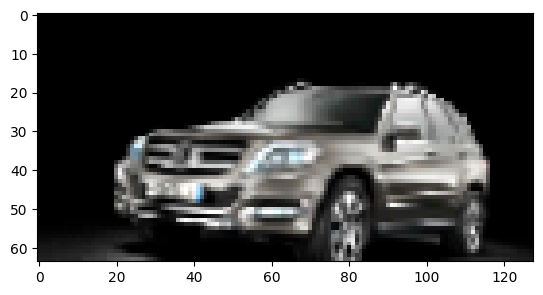

In [ ]:
# Проверка одного изображения из выборки
plt.imshow(train_generator[1][0][2])
plt.show()

In [ ]:
train_generator[1][0][2]

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.19607845, 0.19607845, 0.19607845],
        [0.18823531, 0.18823531, 0.18823531],
        [0.19215688, 0

In [ ]:
# Функция рисования образцов изображений из заданной выборки

def show_batch(batch,                # батч с примерами
               img_range=range(20),  # диапазон номеров картинок
               figsize=(25, 8),      # размер полотна для рисования одной строки таблицы
               columns=5             # число колонок в таблице
               ):

    for i in img_range:
        ix = i % columns
        if ix == 0:
            fig, ax = plt.subplots(1, columns, figsize=figsize)
        class_label = np.argmax(batch[1][i])
        ax[ix].set_title(CLASS_LIST[class_label])
        ax[ix].imshow(batch[0][i])  
        ax[ix].axis('off')
        plt.tight_layout()

    plt.show()

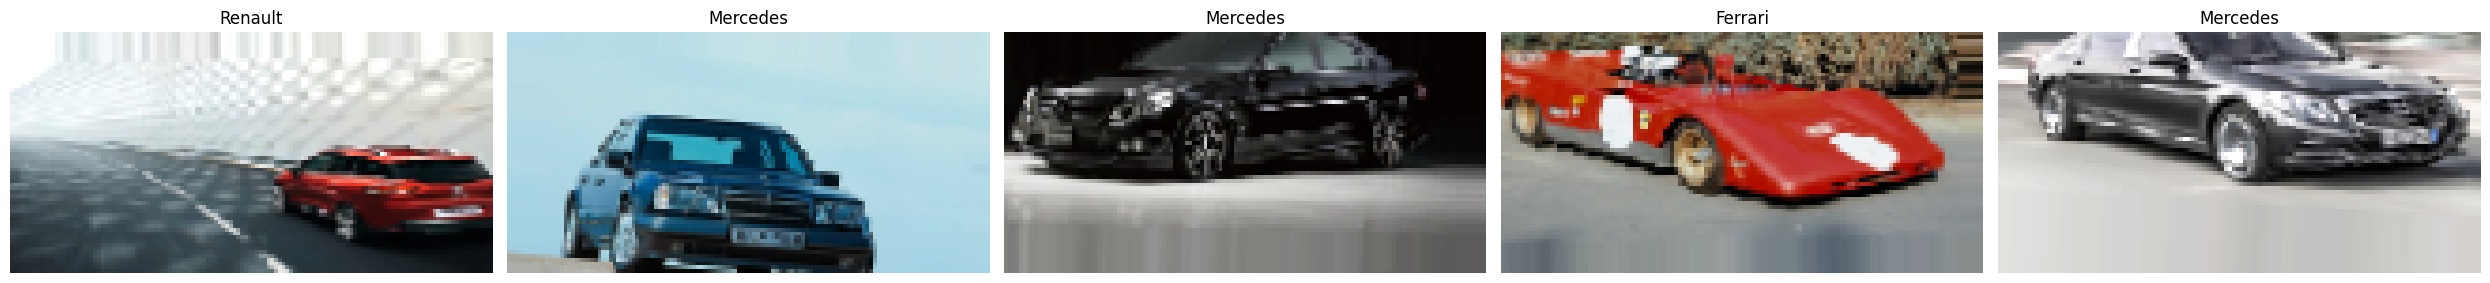

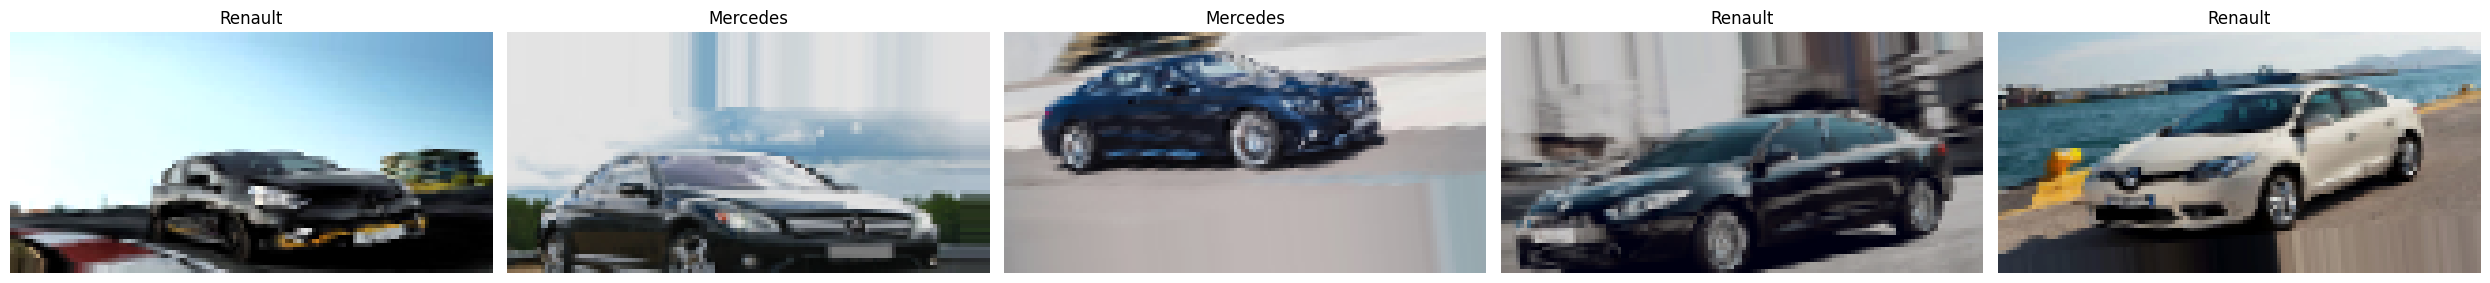

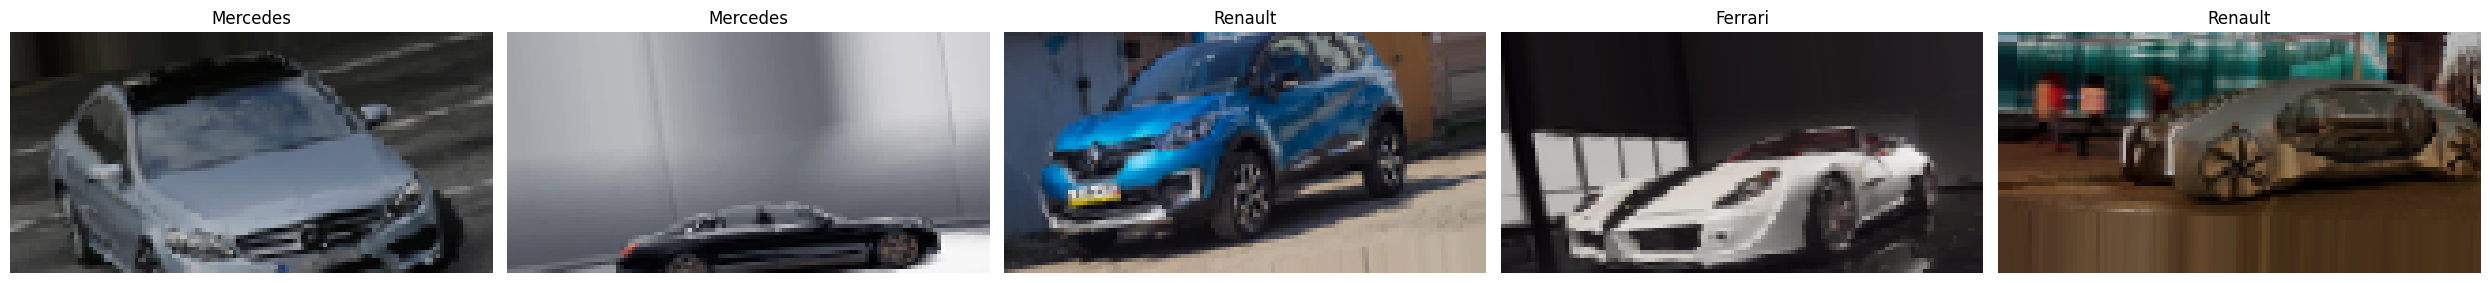

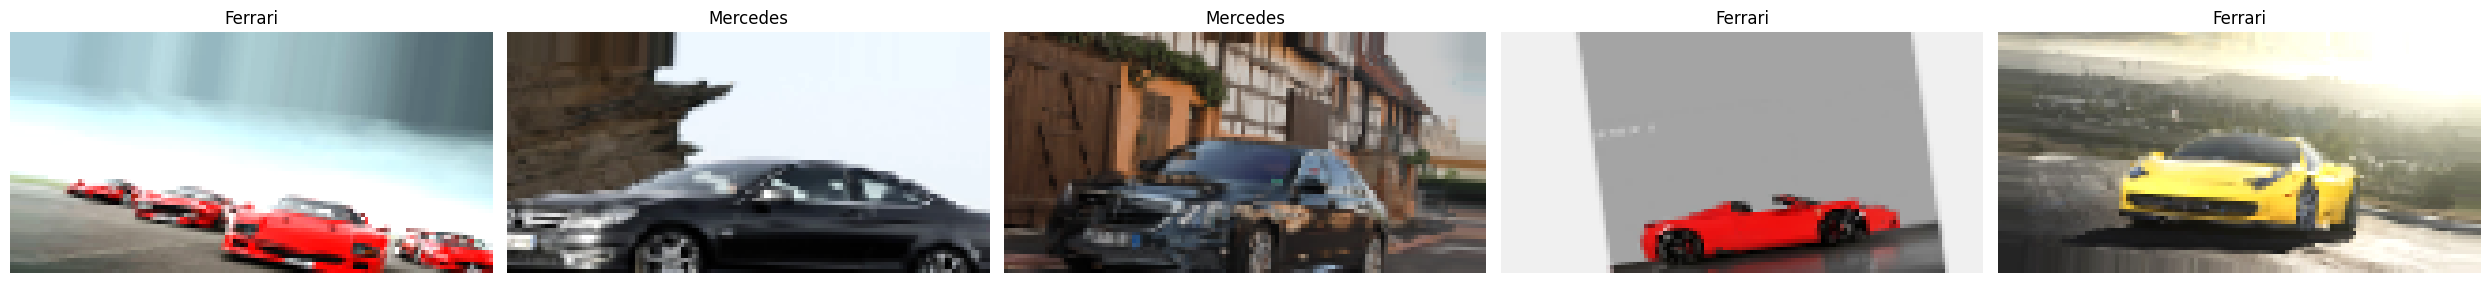

In [ ]:
# Вывод примеров из 0-го батча train_generator
show_batch(train_generator[0])  

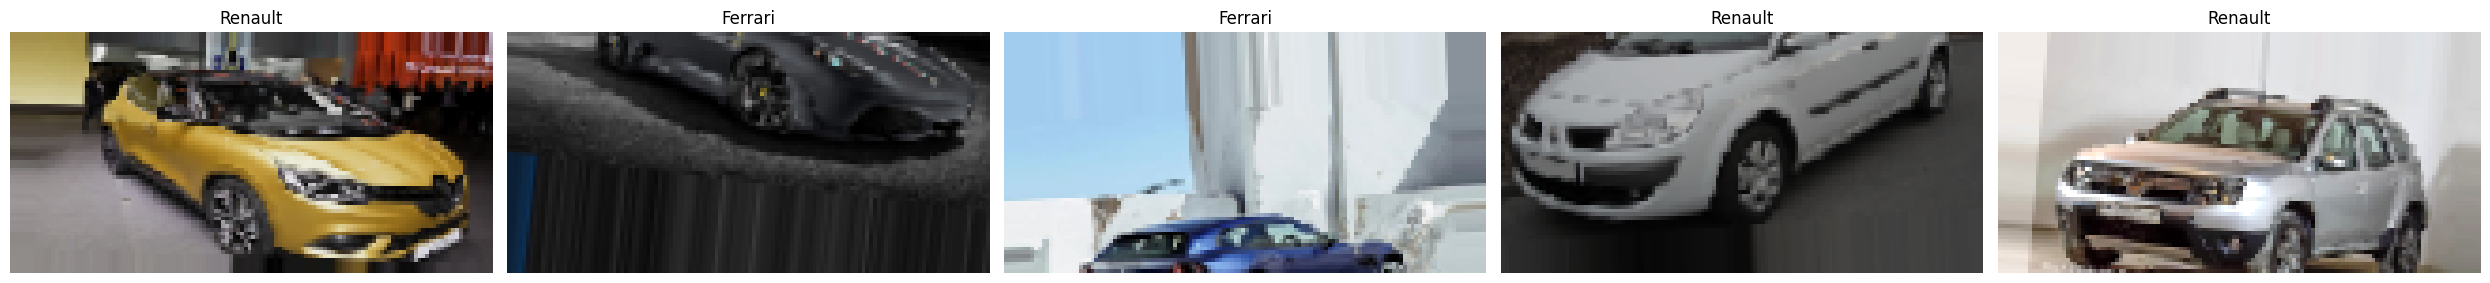

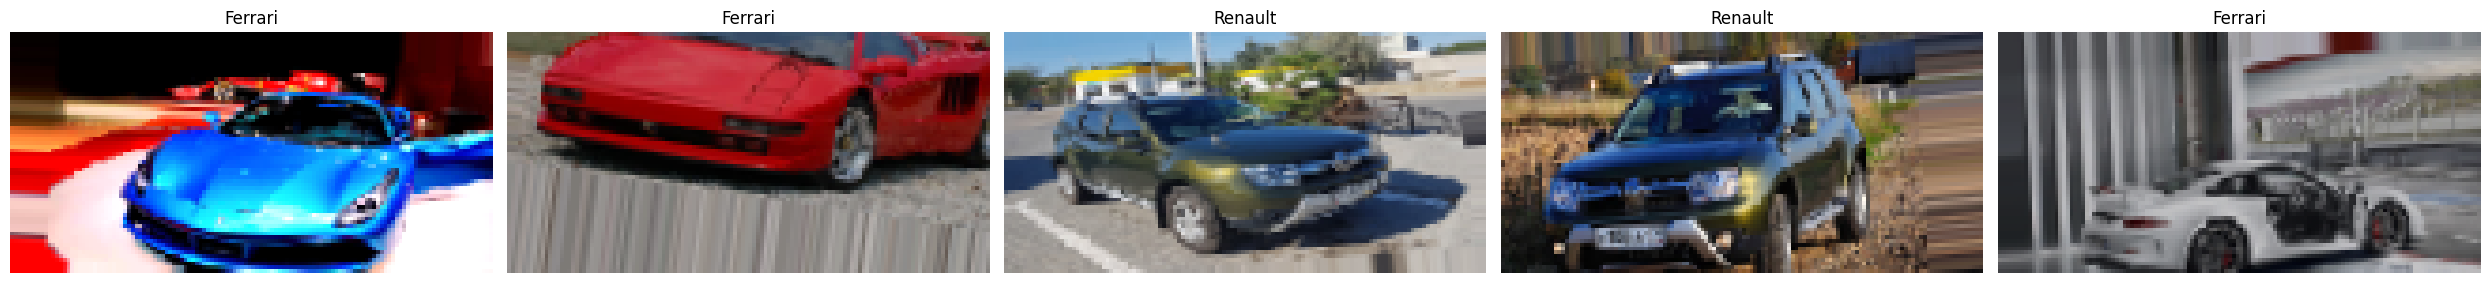

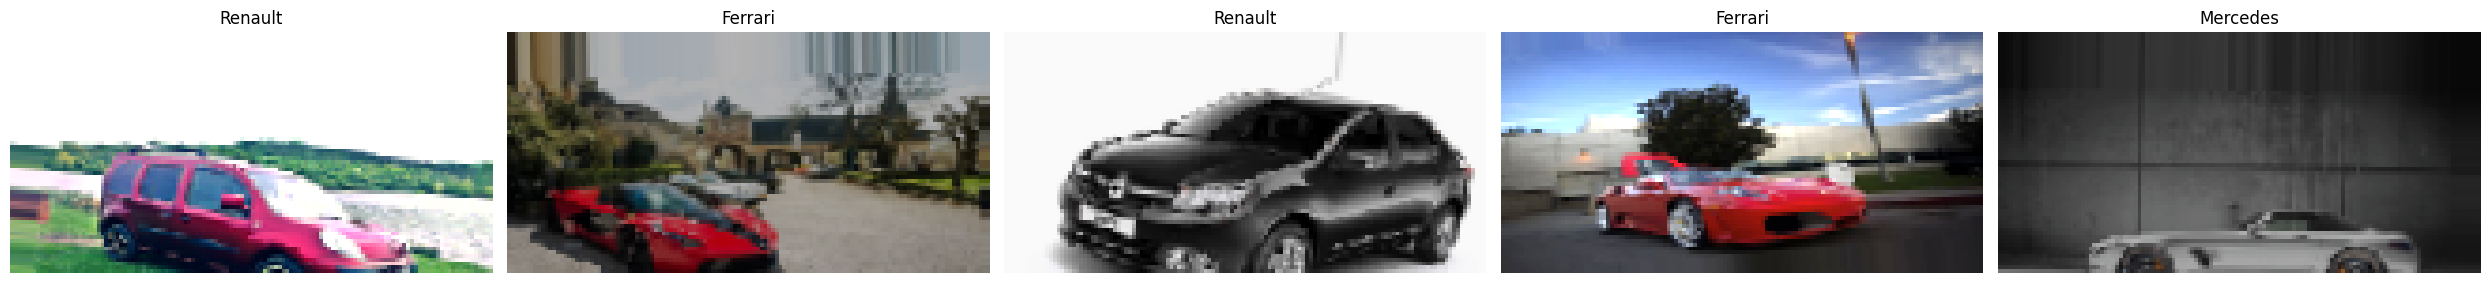

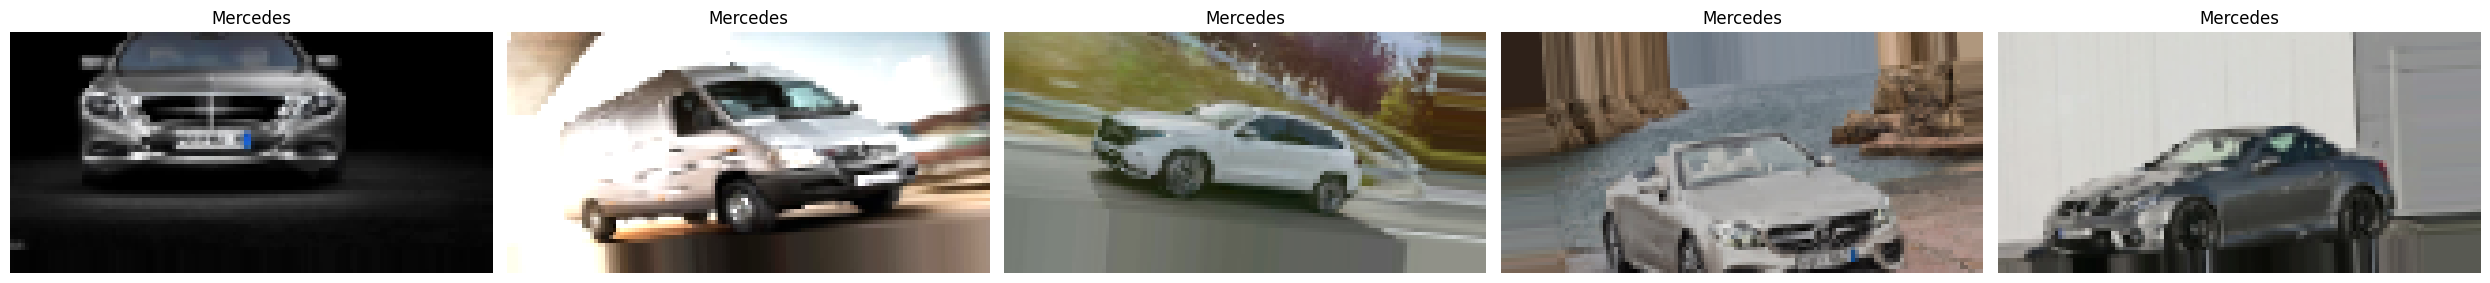

In [ ]:
# Вывод примеров из 0-го батча validation_generator
show_batch(validation_generator[0])

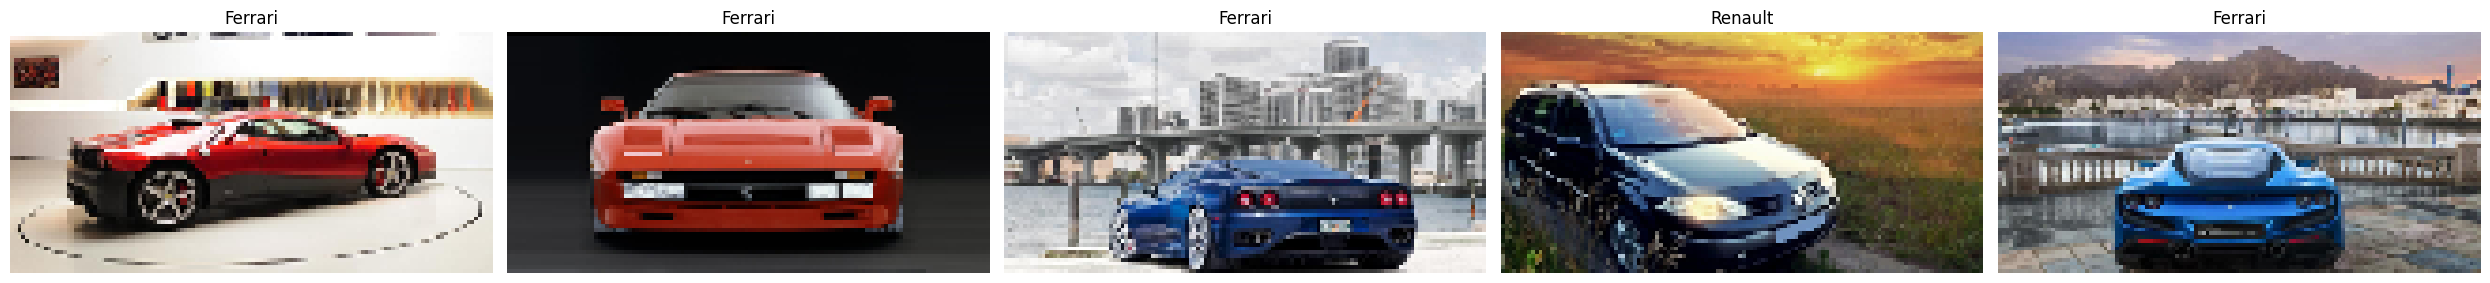

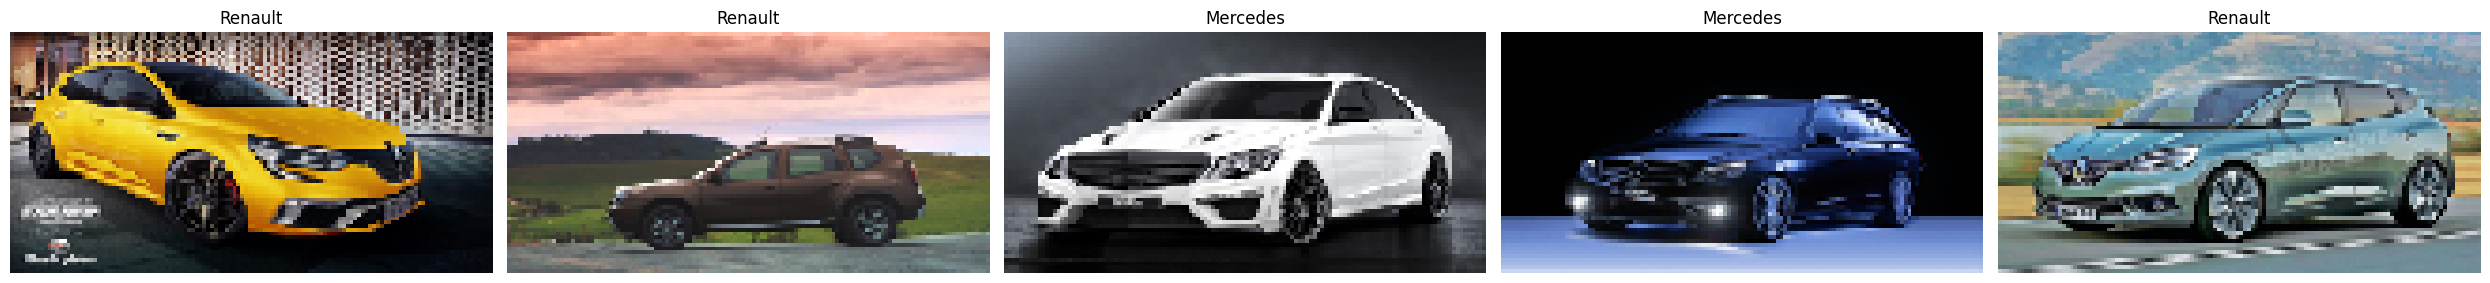

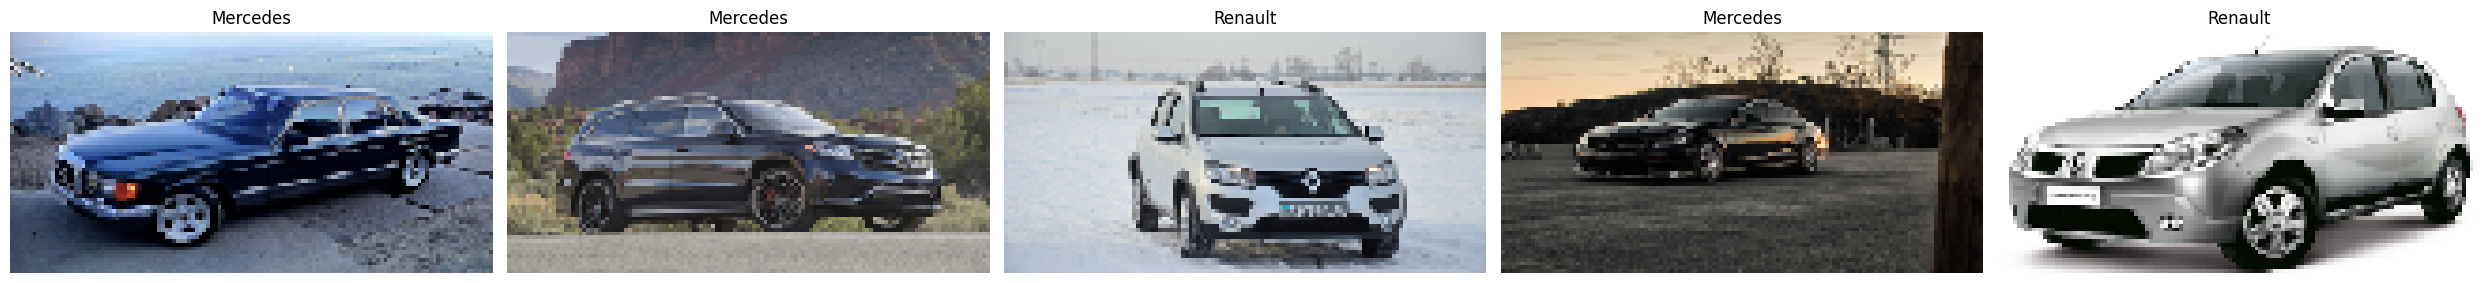

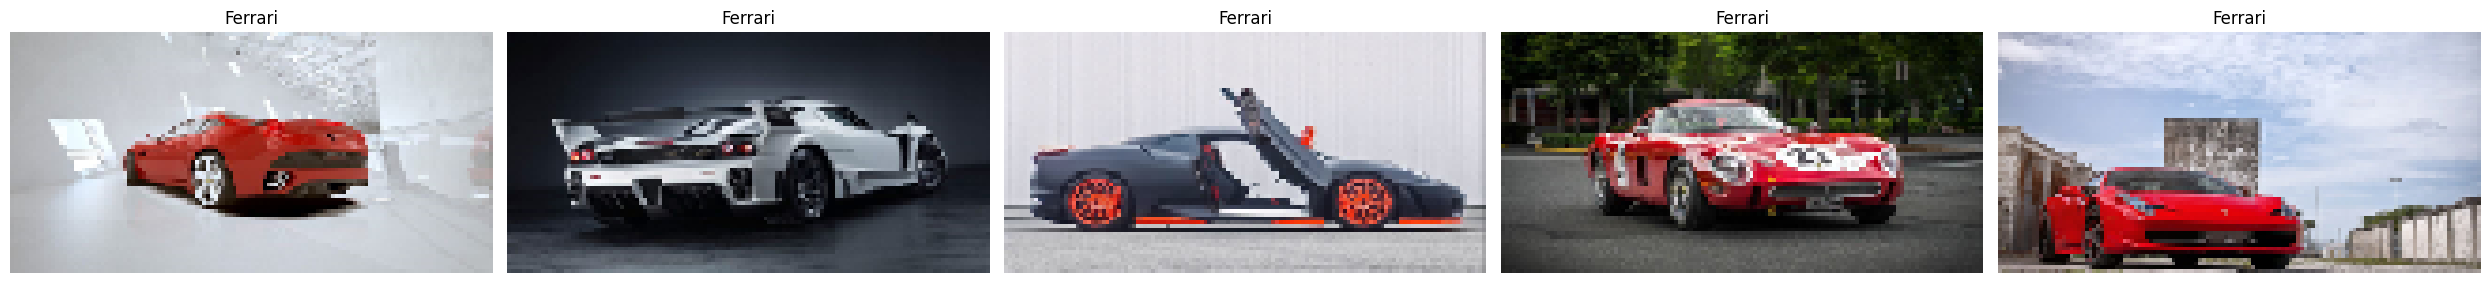

In [ ]:
# Вывод примеров из 0-го (единственного) батча test_generator
show_batch(test_generator[0])

## Создание и обучение модели нейронной сети

### Cервисные функции


In [ ]:
# Функция компиляции и обучения модели нейронной сети
# По окончанию выводит графики обучения

def compile_train_model(model,                  # модель нейронной сети
                        train_data,             # обучающие данные
                        val_data,               # проверочные данные
                        optimizer=OPTIMIZER,    # оптимизатор
                        epochs=EPOCHS,          # количество эпох обучения
                        batch_size=BATCH_SIZE,  # размер батча
                        figsize=(20, 5)):       # размер полотна для графиков

    # Компиляция модели
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(train_data,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=val_data)

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'], 
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'], 
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'], 
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'], 
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

In [ ]:
# Функция вывода результатов оценки модели на заданных данных

def eval_model(model, 
               x,                # данные для предсказания модели (вход)
               y_true,           # верные метки классов в формате OHE (выход)
               class_labels=[],  # список меток классов
               cm_round=3,       # число знаков после запятой для матрицы ошибок
               title='',         # название модели
               figsize=(10, 10)  # размер полотна для матрицы ошибок
               ):
    # Вычисление предсказания сети
    y_pred = model.predict(x)
    # Построение матрицы ошибок
    cm = confusion_matrix(np.argmax(y_true, axis=1),
                          np.argmax(y_pred, axis=1),
                          normalize='true')
    # Округление значений матрицы ошибок
    cm = np.around(cm, cm_round)

    # Отрисовка матрицы ошибок
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(f'Нейросеть {title}: матрица ошибок нормализованная', fontsize=18)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(ax=ax)
    ax.images[-1].colorbar.remove()       # Стирание ненужной цветовой шкалы
    fig.autofmt_xdate(rotation=45)        # Наклон меток горизонтальной оси
    plt.xlabel('Предсказанные классы', fontsize=16)
    plt.ylabel('Верные классы', fontsize=16)
    plt.show()    

    print('-'*100)
    print(f'Нейросеть: {title}')

    # Для каждого класса:
    for cls in range(len(class_labels)):
        # Определяется индекс класса с максимальным значением предсказания (уверенности)
        cls_pred = np.argmax(cm[cls])
        # Формируется сообщение о верности или неверности предсказания
        msg = 'ВЕРНО :-)' if cls_pred == cls else 'НЕВЕРНО :-('
        # Выводится текстовая информация о предсказанном классе и значении уверенности
        print('Класс: {:<20} {:3.0f}% сеть отнесла к классу {:<20} - {}'.format(class_labels[cls],
                                                                               100. * cm[cls, cls_pred],
                                                                               class_labels[cls_pred],
                                                                               msg))

    # Средняя точность распознавания определяется как среднее диагональных элементов матрицы ошибок
    print('\nСредняя точность распознавания: {:3.0f}%'.format(100. * cm.diagonal().mean()))

In [ ]:
# Совместная функция обучения и оценки модели нейронной сети

def compile_train_eval_model(model,                    # модель нейронной сети
                             train_data,               # обучающие данные
                             val_data,                 # проверочные данные
                             test_data,                # тестовые данные
                             class_labels=CLASS_LIST,  # список меток классов
                             title='',                 # название модели
                             optimizer=OPTIMIZER,      # оптимизатор
                             epochs=EPOCHS,            # количество эпох обучения
                             batch_size=BATCH_SIZE,    # размер батча
                             graph_size=(20, 5),       # размер полотна для графиков обучения
                             cm_size=(10, 10)          # размер полотна для матрицы ошибок
                             ):

    # Компиляция и обучение модели на заданных параметрах
    # В качестве проверочных используются тестовые данные
    compile_train_model(model, 
                        train_data,
                        val_data,
                        optimizer=optimizer,
                        epochs=epochs,
                        batch_size=batch_size,
                        figsize=graph_size)

    # Вывод результатов оценки работы модели на тестовых данных
    eval_model(model, test_data[0][0], test_data[0][1], 
               class_labels=class_labels, 
               title=title,
               figsize=cm_size)

### Архитектура модели нейронной сети


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 128, 64, 256)      7168      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 42, 21, 256)      0         
 g2D)                                                            
                                                                 
 batch_normalization_35 (Bat  (None, 42, 21, 256)      1024      
 chNormalization)                                                
                                                                 
 dropout_40 (Dropout)        (None, 42, 21, 256)       0         
                                                                 
 batch_normalization_36 (Bat  (None, 42, 21, 256)      1024      
 chNormalization)                                                
                                                      

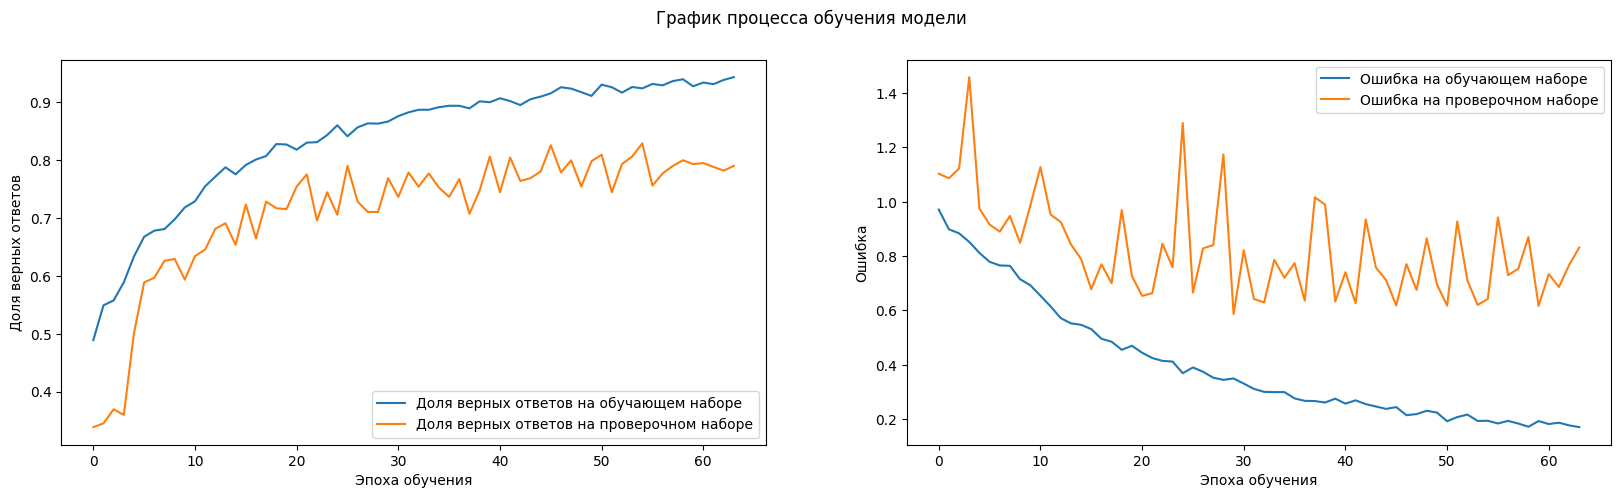

ValueError: ignored

In [ ]:
# Создание последовательной модели
model1= Sequential()

model1.add(Conv2D(256, (3, 3), padding='same', activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)))
model1.add(MaxPooling2D(pool_size=(3, 3))) # Укажем pool_size=(3, 3)    128*64*3 -> 42*21*1024
model1.add(BatchNormalization())
model1.add(Dropout(0.3))

model1.add(BatchNormalization())
model1.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(3, 3)))                             # 42*21*1024 -> 14*7*2048
model1.add(Dropout(0.3))

model1.add(BatchNormalization())
model1.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(3, 3)))                             # 4*2*2048
model1.add(Dropout(0.3))

model1.add(BatchNormalization())
model1.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))                      
model1.add(Dropout(0.3))

model1.add(Conv2D(1024, (3, 3), padding='same', activation='relu'))
model1.add(Conv2D(2048, (3, 3), padding='same', activation='relu'))
model1.add(Dropout(0.3))


model1.add(Flatten())
model1.add(Dense(2048, activation='relu'))
model1.add(Dense(4096, activation='relu'))
model1.add(Dense(CLASS_COUNT, activation='softmax'))


# Обучение модели и вывод оценки ее работы на тестовых данных
compile_train_eval_model(model1,
                         train_generator,
                         validation_generator,
                         test_generator,
                         class_labels=CLASS_LIST,
                         title='Сверточный классификатор')

# Решение с помощью готовой архитектуры ResNet50

Для решения задачи мы воспользуемся архитектурой ResNet50

In [ ]:
# Загрузка zip-архива с базой с сервера УИИ
!wget -q 'https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip'

# Распаковка архива
!unzip -q "middle_fmr.zip" -d /content/cars_pretrained 

In [ ]:
data_dir = '/content/cars_pretrained/'  # Присваиваем путь к базе в переменную data_dir
os.listdir(data_dir) 
batch_size = 32             # Определяем batch size
image_size = (224, 224)     # Определяем размер изображений

Датасет состоит из трех классов:
CLASS_LIST = ['Ferrari', 'Mercedes', 'Renault']

## Загрузка библиотек

In [ ]:
import tensorflow as tf          # Библиотека TensorFlow
from tensorflow.keras.preprocessing import image # Для работы с изображениями
# метод для отрисовки модели 
from keras.utils.vis_utils import plot_model
import gc                        # Модуль Garbage Collector - для помощи в освобождении памяти (Удаляет лишние/неиспользуемые данные)
import os                        # Модуль для работы с файлами операционной системы
import time                      # Модуль для работы со временем
import gdown                     # Модуль для загрузки больших файлов
import random                    # Модуль для генерации случайных значений
import seaborn as sns            # Модуль для работы с графиками и стилями
import matplotlib.pyplot as plt  # Модуль для работы с графиками и изображениями
from PIL import Image            # Методы для работы с изображениями     
import seaborn as sns            # Модуль для работы с графиками и стилями

## Подготовка ДС

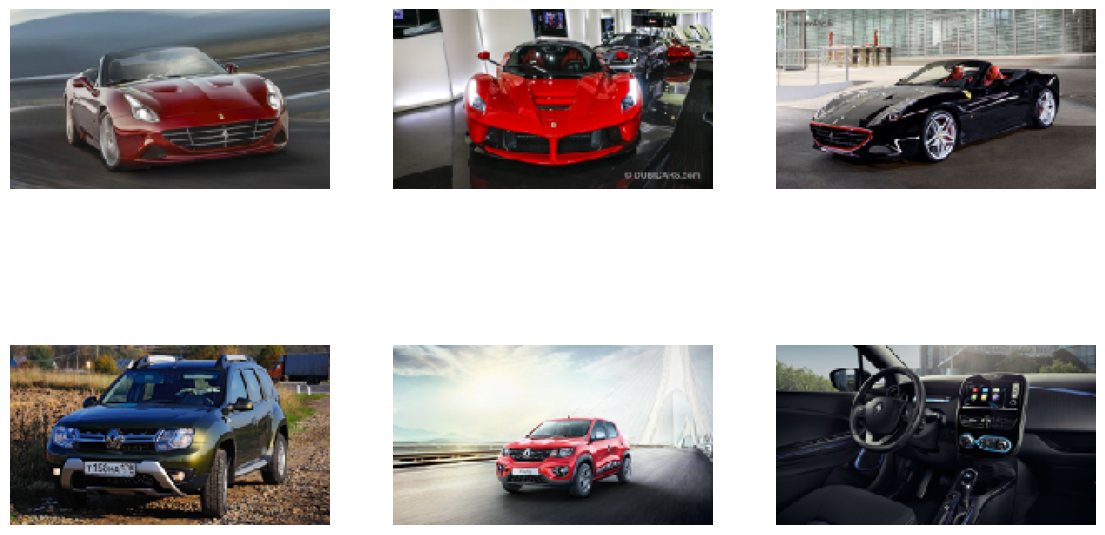

In [ ]:
Ferrari = os.listdir(data_dir + '/Ferrari')       # Путь до изображений Ferrari
Mercedes = os.listdir(data_dir + '/Mercedes')     # Путь до изображений Mercedes
Renault = os.listdir(data_dir + '/Renault')       # Путь до изображений Renault
count = 3                                         # Укажем количество изображений

                                                # Выведем на экран примеры случайных изображений:
f, ax = plt.subplots(2, count, figsize=(14,8))

for i in range(count):  
  sample = random.choice(Ferrari)                   # Используем метод random.choice() для выбора случайных изображений
  ax[0,i].imshow(Image.open(data_dir + 'Ferrari/' + sample))
  ax[0,i].axis('off')
  
for i in range(count):  
  sample = random.choice(Mercedes)                   # Используем метод random.choice() для выбора случайных изображений
  ax[1,i].imshow(Image.open(data_dir + 'Mercedes/' + sample))
  ax[1,i].axis('off')

for i in range(count):  
  sample = random.choice(Renault)                   # Используем метод random.choice() для выбора случайных изображений
  ax[1,i].imshow(Image.open(data_dir + 'Renault/' + sample))
  ax[1,i].axis('off')
plt.show()

С помощью метода `image_dataset_from_directory` создадим обучающий и проверочный датасеты:

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,                  # Путь к изображениям
  validation_split = 0.2,    # Устанавливаем разделение на обучающую и проверочную выборки (20%)
  subset = "training",       # Помечаем, что выборка обучающая (80%)
  seed = 123,                # Дополнительное случайное начальное число для перетасовки и преобразований
  image_size = image_size,   # Размер изображений, который был задан ранее
  batch_size = batch_size)   # Размер батча, который был задан ранее

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,                  # Путь к изображениям
  validation_split = 0.2,    # Устанавливаем разделение на обучающую и проверочную выборки (20%)
  subset = "validation",     # Помечаем, что выборка проверочная (20%)
  seed = 123,                # Дополнительное случайное начальное число для перетасовки и преобразований
  image_size = image_size,   # Размер изображений, который был задан ранее
  batch_size = batch_size)   # Размер батча, который был задан ранее
  
                             # Определяем имена классов:
class_names = train_ds.class_names
print(class_names)

Found 3427 files belonging to 3 classes.
Using 2742 files for training.
Found 3427 files belonging to 3 classes.
Using 685 files for validation.
['Ferrari', 'Mercedes', 'Renault']


In [ ]:
                                                           # Предварительная подгрузка датасета для ускорения обучения и стабилизации
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) # Предварительная обучающая выборка
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)     # Предварительная тестовая выборка

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


Дополнительные слои для модели, с помощью которых можно провести дополнительную аугментацию

In [ ]:
                                                                        # Дополнительная аугментация в виде слоя для модели (для увеличения базы изображений)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomZoom((-0.05, 0.05)), # Произвольное увеличение и уменьшение на 10%
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.15)])     # Изменение контраста изображений 

Дополнительная функция для отрисовки графиков обучения

In [ ]:
def plot_graph(train_acc, val_acc, train_loss, val_loss):
  '''
  Функция выведет на экран графики точности и ошибки на проверочной и обучающей выборках.
  '''
  sns.set(style='darkgrid', palette='dark') 
  plt.figure(figsize=(16, 10))
  plt.subplot(2, 2, 1)
  plt.title('Точность', fontweight='bold')
  plt.plot(train_acc, label='Точность на обучащей выборке')
  plt.plot(val_acc, label='Точность на проверочной выборке')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.title('Ошибка', fontweight='bold')
  plt.plot(train_loss, label='Ошибка на обучающей выборке')
  plt.plot(val_loss, label='Ошибка на проверочной выборке')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()

  plt.show()

## Применение готовой модели

In [ ]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input  # Нормализация данных на вход в соответствии требованиям модели
gc.collect()                                                        # Сборка мусора для освобождения памяти
image_shape = image_size + (3,)                                     # Определяем входную размерность в соответствии требованиям модели
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()     # Задаем слой GlobalAveragePooling2D
prediction_layer = tf.keras.layers.Dense(len(class_names))          # Задаем выходной слой на нужное нам количество классов


                                                                    # Создаем базовую модель ResNet50:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=image_shape,
                         include_top=False,                         # Не включаем верхнюю часть модели, чтобы можно было использовать свои входные размерности
                         weights='imagenet')                        # Используем веса уже предобученной модели на базе Imagenet


                                                                    # Собираем полную модель, состоящую из всех наших определенных слоев и базовой модели ResNet50:
inputs = tf.keras.Input(shape=(image_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
base_learning_rate = 0.0001                                                          # Задаем значение шага обучения
epochs = 10                                                                          # Задаем количество эпох

                                                                                     # Компилируем модель:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),  # Оптимизатор Adam c заданным ранее шагом обучения
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  # Ошибка SparseCategoricalCrossentropy
              metrics=['accuracy'])                                                  # Метрика Accuracy

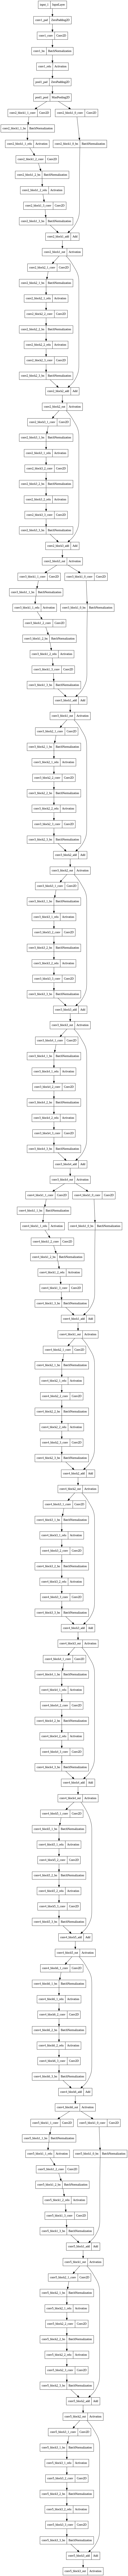

In [ ]:
plot_model(base_model)

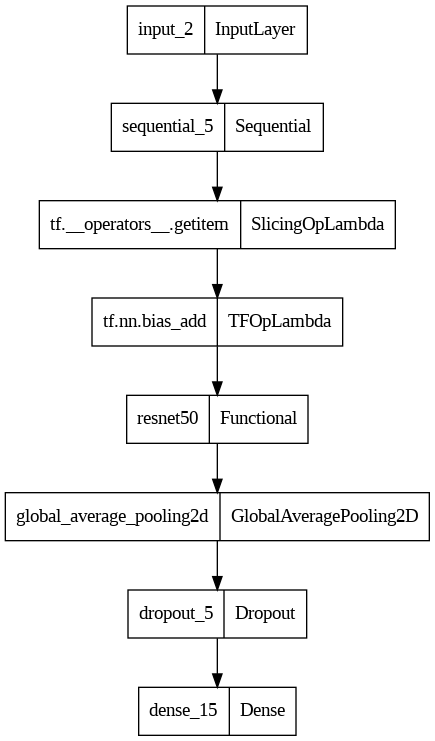

In [ ]:
plot_model(model)

Epoch 1/10
86/86 [==============================] - 80s 439ms/step - loss: 0.7941 - accuracy: 0.6499 - val_loss: 0.5606 - val_accuracy: 0.7737
Epoch 2/10
86/86 [==============================] - 32s 367ms/step - loss: 0.4452 - accuracy: 0.8293 - val_loss: 0.3832 - val_accuracy: 0.8569
Epoch 3/10
86/86 [==============================] - 32s 373ms/step - loss: 0.1922 - accuracy: 0.9311 - val_loss: 0.2063 - val_accuracy: 0.9226
Epoch 4/10
86/86 [==============================] - 31s 365ms/step - loss: 0.1830 - accuracy: 0.9311 - val_loss: 0.2263 - val_accuracy: 0.9168
Epoch 5/10
86/86 [==============================] - 32s 372ms/step - loss: 0.1341 - accuracy: 0.9540 - val_loss: 0.2661 - val_accuracy: 0.9109
Epoch 6/10
86/86 [==============================] - 32s 369ms/step - loss: 0.0728 - accuracy: 0.9734 - val_loss: 0.1849 - val_accuracy: 0.9401
Epoch 7/10
86/86 [==============================] - 31s 365ms/step - loss: 0.0546 - accuracy: 0.9814 - val_loss: 0.2813 - val_accuracy: 0.9285

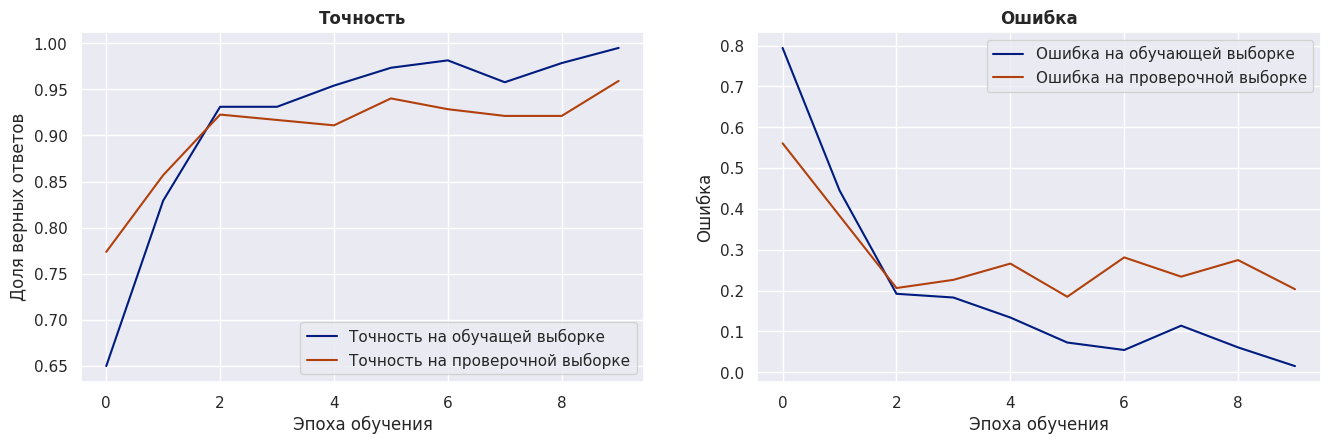

Время обучения: 411 секунд (6.85 минут)


In [ ]:
CurrentTime = time.time()                       # Засекаем время для измерения времени обучения нейронной сети

                                                # Обучаем модель:
hResNet50 = model.fit(train_ds,                 # Обучающая выборка
                      epochs=epochs,            # Количество эпох обучения, заданное ранее
                      validation_data=val_ds)   # Проверочная выборка

                                                # После того, как пройдет обучение, выведем графики точности и ошибки:
plot_graph(hResNet50.history['accuracy'],
           hResNet50.history['val_accuracy'],
           hResNet50.history['loss'],
           hResNet50.history['val_loss'])

print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))

# Выводы

фывфывфывфывфыв